Task 3: Dimensionality Reduction

Here is the third part and it is about dimentionality reduction. How to map high-dimentional data into low-dimensional space is an interesting topic in machine learning field. And also, it is related to another hot topic -- unsupervised learning. Now, in this section, you are going to learn two different methods for this question.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [2]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

We will use the CIFAR-10 dataset.

In [3]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./ecbm4040/features/pca.py**.

### Naive PCA

In [4]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [5]:
# Start PCA
K = 200
P, T = pca_naive(X_patch, K)

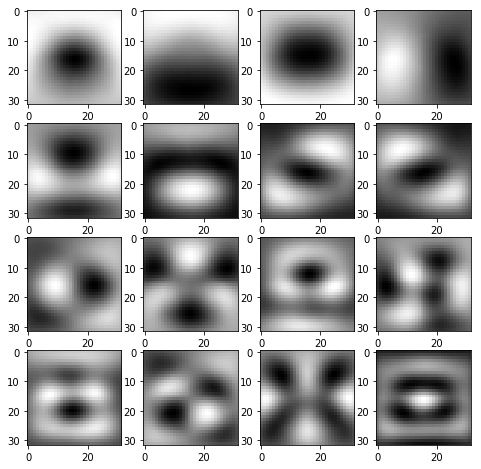

In [6]:
# TODO: Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

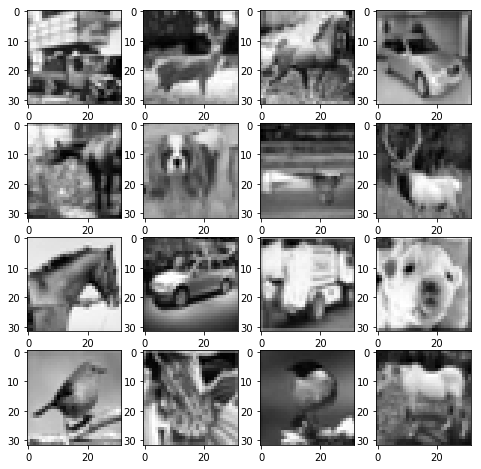

In [7]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

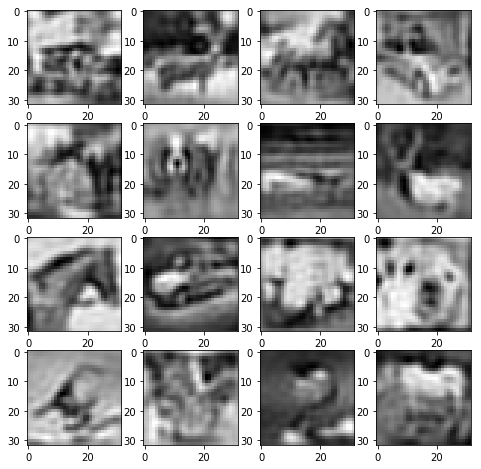

In [8]:
# TODO: Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [24]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

# TODO: pca preprocessing -> mlp classification
for i in range(3):
    
    #Loading data
    temp1 = X_train[:,:,:,i]
    temp2 = X_val[:,:,:,i]
    temp3 = X_test[:,:,:,i]
    
    #Reshaping it to 1024
    N = temp1.shape[0]
    temp1_new = temp1.reshape(N,1024)
    N = temp2.shape[0]
    temp2_new = temp2.reshape(N,1024)
    N = temp3.shape[0]
    temp3_new = temp3.reshape(N,1024)
    
    #Printing shapes
    print(temp1_new.shape)
    print(temp2_new.shape)
    print(temp3_new.shape)
    
    #Reducing dimensions
    redu_train = temp1_new.dot(P.T)
    redu_val = temp2_new.dot(P.T)
    redu_test = temp3_new.dot(P.T)
    
    print(redu_train.shape)
    print(redu_val.shape)
    print(redu_test.shape)
    
    if i==0:
        new_train = redu_train
        new_val = redu_val
        new_test = redu_test
    else:
        new_train = np.concatenate((new_train, redu_train), axis=1)
        new_val = np.concatenate((new_val, redu_val), axis=1)
        new_test = np.concatenate((new_test, redu_test), axis=1)
print(new_train.shape)
print(new_val.shape)
print(new_test.shape)
model = MLP(input_dim=600, hidden_dims=[100, 50], num_classes=10, reg=0.1, weight_scale=1e-3)
num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = True
train_acc_hist, val_acc_hist = train(model, new_train, y_train, new_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, new_test, y_test)

(49000, 1024)
(1000, 1024)
(10000, 1024)
(49000, 200)
(1000, 200)
(10000, 200)
(49000, 1024)
(1000, 1024)
(10000, 1024)
(49000, 200)
(1000, 200)
(10000, 200)
(49000, 1024)
(1000, 1024)
(10000, 1024)
(49000, 200)
(1000, 200)
(10000, 200)
(49000, 600)
(1000, 600)
(10000, 600)
number of batches for training: 98
5000/49000 loss: 2.303434178161039
10000/49000 loss: 2.3030710727771146
15000/49000 loss: 2.302331082967776
20000/49000 loss: 2.2982498273868734
25000/49000 loss: 2.2849432415666935
30000/49000 loss: 2.2339167569061487
35000/49000 loss: 2.2163966777211463
40000/49000 loss: 2.207719786149118
45000/49000 loss: 2.151581606242641
epoch 1: valid acc = 0.19, new learning rate = 0.0095
5000/49000 loss: 2.134332759272502
10000/49000 loss: 2.166910407751084
15000/49000 loss: 2.1933016793677016
20000/49000 loss: 2.174076558224306
25000/49000 loss: 2.185094354188524
30000/49000 loss: 2.1367583517601876
35000/49000 loss: 2.1681677294754222
40000/49000 loss: 2.1689032007356737
45000/49000 loss:

0.39229999999999998

<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

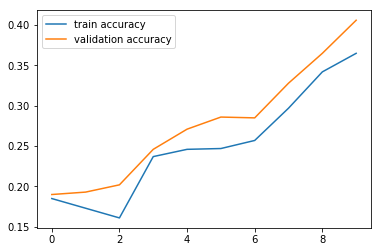

In [25]:
# TODO:
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE (not graded)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [18]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [19]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.45838707352
The 100 th loop cost: 13.893461285131643, computation time: 1.7777080535888672
The 200 th loop cost: 1.136498301028991, computation time: 3.4660580158233643
The 300 th loop cost: 1.132595738097693, computation time: 5.1610729694366455
The 400 th loop cost: 1.1325574810046934, computation time: 6.846564054489136
The 500 th loop cost: 1.132557432317858, computation time: 8.530954122543335
The 600 th loop cost: 1.1325574322538083, computation time: 10.320264101028442
The 700 th loop cost: 1.1325574322536962, computation time: 12.185001134872437
The 800 th loop cost: 1.132557432253695, computation time: 14.014189004898071
The 900 th loop cost: 1.132557432253695, computation time: 15.711263179779053
The 1000 th loop cost: 1.132557432253695, computation time: 17.407294034957886
it takes 17.974875926971436 seconds


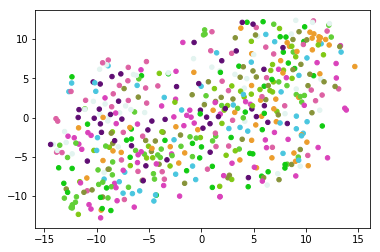

In [20]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [21]:
# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-2)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245


/Users/Mohneesh/Desktop/DLassignment1/ecbm4040/layer_funcs.py:127: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


epoch 1: valid acc = 0.314, new learning rate = 0.00095
epoch 2: valid acc = 0.359, new learning rate = 0.0009025
epoch 3: valid acc = 0.397, new learning rate = 0.000857375
epoch 4: valid acc = 0.44, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.458, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.473, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.477, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.486, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.491, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.501, new learning rate = 0.0005987369392383785
test acc: 0.4925


0.49249999999999999

In [22]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.1898830216
The 100 th loop cost: 11.277836324171659, computation time: 1.622952938079834
The 200 th loop cost: 0.501735703850788, computation time: 3.0523741245269775
The 300 th loop cost: 0.48564410601566205, computation time: 4.491385221481323
The 400 th loop cost: 0.4840679771150704, computation time: 6.156728029251099
The 500 th loop cost: 0.48391558112182853, computation time: 7.875942945480347
The 600 th loop cost: 0.4838938021052863, computation time: 9.320127964019775
The 700 th loop cost: 0.48389026669618423, computation time: 10.761606931686401
The 800 th loop cost: 0.4838896631057872, computation time: 12.194993019104004
The 900 th loop cost: 0.48388955908340875, computation time: 13.635747194290161
The 1000 th loop cost: 0.48388954068155304, computation time: 15.074590921401978
it takes 15.636842966079712 seconds


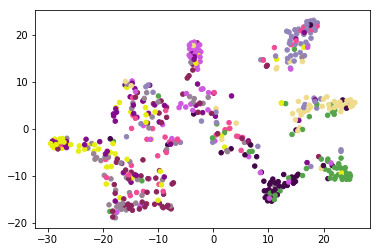

In [23]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()